In [1]:
# In[1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.transformation import LogTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
#%%
dataset_dir = '../datasets/titanic/'
jobs = -1
cross_validation = 10

df = pd.read_csv(dataset_dir + 'train.csv')

# Name is not an important feature in our analysis
# Ticket number may indicate being in the same family, but I'll exclude for simplicity
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

FEATURES = ['Cabin', 'Fare', 'Sex', 'Age', 'Parch']

X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], # predictive variables
    df['Survived'],               # target
    test_size = 0.2,                # portion of dataset to allocate to test set
    random_state = 0,               # we are setting the seed here
)

#%%

In [3]:
X_train

,Cabin,Fare,Sex,Age,Parch
140,NaN,15.2458,female,NaN,2
439,NaN,10.5000,male,31.0,0
817,NaN,37.0042,male,31.0,1
378,NaN,4.0125,male,20.0,0
491,NaN,7.2500,male,21.0,0
...,...,...,...,...,...
835,E49,83.1583,female,39.0,1
192,NaN,7.8542,female,19.0,0
629,NaN,7.7333,male,NaN,0
559,NaN,17.4000,female,36.0,0


In [4]:
class MissingBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna('Missing')
            X[feature] = np.where(X[feature] == 'Missing', 0, 1)

        return X
#%%

In [5]:
X_train_1 = MissingBinaryTransformer(variables=['Cabin']).transform(X_train)
X_train_1

,Cabin,Fare,Sex,Age,Parch
140,0,15.2458,female,NaN,2
439,0,10.5000,male,31.0,0
817,0,37.0042,male,31.0,1
378,0,4.0125,male,20.0,0
491,0,7.2500,male,21.0,0
...,...,...,...,...,...
835,1,83.1583,female,39.0,1
192,0,7.8542,female,19.0,0
629,0,7.7333,male,NaN,0
559,0,17.4000,female,36.0,0


#### 上述可將CABIN欄位的NAN值改為0，而且有值的改為1

In [6]:
X_train_2 = AddMissingIndicator(missing_only=True, variables=['Age']).fit_transform(X_train_1)
X_train_2

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,female,NaN,2,1
439,0,10.5000,male,31.0,0,0
817,0,37.0042,male,31.0,1,0
378,0,4.0125,male,20.0,0,0
491,0,7.2500,male,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,female,39.0,1,0
192,0,7.8542,female,19.0,0,0
629,0,7.7333,male,NaN,0,1
559,0,17.4000,female,36.0,0,0


In [7]:
X_train_3 = MeanMedianImputer(imputation_method='median', variables=['Age']).fit_transform(X_train_2)
X_train_3

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,female,29.0,2,1
439,0,10.5000,male,31.0,0,0
817,0,37.0042,male,31.0,1,0
378,0,4.0125,male,20.0,0,0
491,0,7.2500,male,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,female,39.0,1,0
192,0,7.8542,female,19.0,0,0
629,0,7.7333,male,29.0,0,1
559,0,17.4000,female,36.0,0,0


In [8]:
class GenderBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.where(X[feature] == 'female', 0, 1)

        return X

In [9]:
X_train_4 = GenderBinaryTransformer(variables=['Sex']).transform(X_train_3)
X_train_4

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,0,29.0,2,1
439,0,10.5000,1,31.0,0,0
817,0,37.0042,1,31.0,1,0
378,0,4.0125,1,20.0,0,0
491,0,7.2500,1,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,0,39.0,1,0
192,0,7.8542,0,19.0,0,0
629,0,7.7333,1,29.0,0,1
559,0,17.4000,0,36.0,0,0


In [11]:
#%%
class NonZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna(int(0))
            X[feature] = np.where(X[feature] < 0.1, 0.1, X[feature])

        return X

In [12]:
X_train_5 = NonZeroTransformer(variables=['Fare']).transform(X_train_4)
X_train_5

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,15.2458,0,29.0,2,1
439,0,10.5000,1,31.0,0,0
817,0,37.0042,1,31.0,1,0
378,0,4.0125,1,20.0,0,0
491,0,7.2500,1,21.0,0,0
...,...,...,...,...,...,...
835,1,83.1583,0,39.0,1,0
192,0,7.8542,0,19.0,0,0
629,0,7.7333,1,29.0,0,1
559,0,17.4000,0,36.0,0,0


In [13]:
X_train_6 = LogTransformer(variables=['Fare']).fit_transform(X_train_5)
X_train_6

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,2.724304,0,29.0,2,1
439,0,2.351375,1,31.0,0,0
817,0,3.611031,1,31.0,1,0
378,0,1.389414,1,20.0,0,0
491,0,1.981001,1,21.0,0,0
...,...,...,...,...,...,...
835,1,4.420746,0,39.0,1,0
192,0,2.061048,0,19.0,0,0
629,0,2.045536,1,29.0,0,1
559,0,2.856470,0,36.0,0,0


In [14]:
X_train_7 = MinMaxScaler().fit_transform(X_train_6) 
X_train_7

array([[0.        , 0.58852172, 0.        , 0.35711585, 0.33333333,
        1.        ],
       [0.        , 0.54486118, 1.        , 0.38232699, 0.        ,
        0.        ],
       [0.        , 0.69233509, 1.        , 0.38232699, 0.16666667,
        0.        ],
       ...,
       [0.        , 0.50905509, 1.        , 0.35711585, 0.        ,
        1.        ],
       [0.        , 0.60399504, 0.        , 0.44535485, 0.        ,
        0.        ],
       [0.        , 0.69848505, 1.        , 0.74788857, 0.16666667,
        0.        ]])

In [16]:
logreg  = LogisticRegression(max_iter = 10000).fit(X_train_7, y_train)
print(f"Training set score of LR: {logreg.score(X_train_7, y_train):.3f}")

Training set score of LR: 0.794


In [21]:
rfreg  = RandomForestRegressor().fit(X_train_7, y_train)
print(f"Training set score of LR: {rfreg.score(X_train_7, y_train):.3f}")

Training set score of LR: 0.887


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


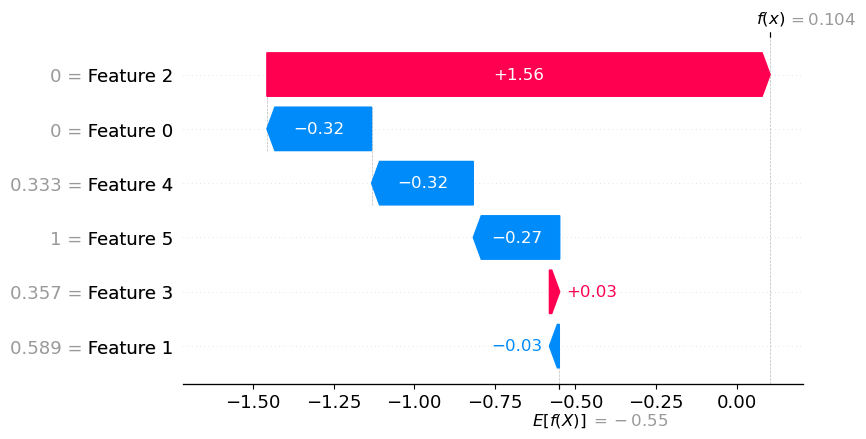

In [18]:
import shap
explainer = shap.Explainer(logreg, X_train_7)
shap_values = explainer(X_train_7[0:1])
shap.plots.waterfall(shap_values[0])

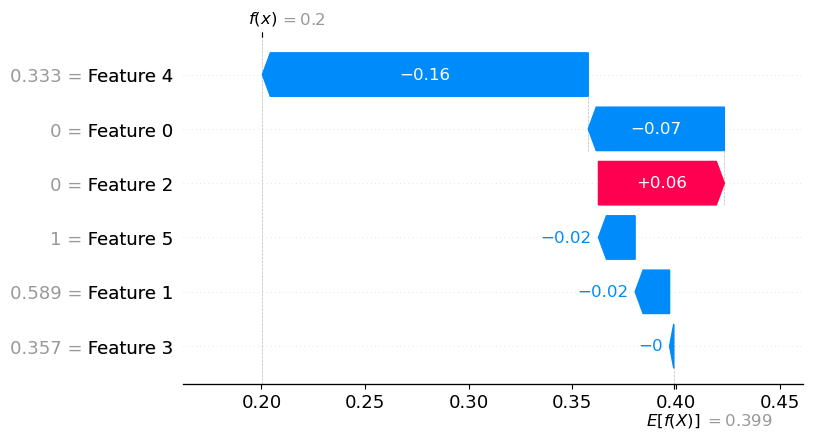

In [23]:
explainer = shap.Explainer(rfreg, X_train_7)
shap_values = explainer(X_train_7[0:1], check_additivity=False)
shap.plots.waterfall(shap_values[0])

In [32]:
def pipe_data_process():   
    dp = Pipeline([
        # -- IMPUTATION --
        ('missing_imputation', MissingBinaryTransformer(variables=['Cabin'])),
        ('missing_indicator', AddMissingIndicator(missing_only=True, variables=['Age'])),
        ('mean_imputation', MeanMedianImputer(imputation_method='median', variables=['Age'])),
    
        # -- TRANSFORMATION --
        ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
        ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
        ('log', LogTransformer(variables=['Fare'])),
        
        # -- SCALING AND PREDICTION -- 
        ('scaler', MinMaxScaler()),        
        ],
        verbose = True)
    
    return dp

In [33]:
def pipe_classification():   
    LR_pipe = Pipeline([
        ('LogisticRegession', LogisticRegression()),],
        verbose = True)
    
    RFR_pipe = Pipeline([
        ('RandomForestRegressor', RandomForestRegressor()),],
        verbose = True)
    
    return LR_pipe, RFR_pipe

In [34]:
X_train_v = pipe_data_process().fit_transform(X_train)
X_test_v = pipe_data_process().fit_transform(X_test)

LR_pipe, RFR_pipe = pipe_classification()

lr_score = LR_pipe.fit(X_train_v, y_train).score(X_test_v, y_test)
rfr_score = RFR_pipe.fit(X_train_v, y_train).score(X_test_v, y_test)
print(f"Testing set score of LR: {lr_score:.3f}")
print(f"Testing set score of RFR: {rfr_score:.3f}")

[Pipeline]  (step 1 of 6) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 6) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 6) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 6) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 6) Processing log, total=   0.0s
[Pipeline]  (step 1 of 6) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 6) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 6) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 6) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 6) Processing log, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 1) Processing RandomForestRegressor, total=   0.4s
Tes

In [42]:
X_train_v

,Cabin,Fare,Sex,Age,Parch,Age_na
140,0,2.724304,0,29.0,2,1
439,0,2.351375,1,31.0,0,0
817,0,3.611031,1,31.0,1,0
378,0,1.389414,1,20.0,0,0
491,0,1.981001,1,21.0,0,0
...,...,...,...,...,...,...
835,1,4.420746,0,39.0,1,0
192,0,2.061048,0,19.0,0,0
629,0,2.045536,1,29.0,0,1
559,0,2.856470,0,36.0,0,0


In [38]:
def pipe_parm():
    # Set grid search params
    params = {
        'LogisticRegession':{
            'LogisticRegession__penalty': ['l1', 'l2'],
            'LogisticRegession__solver': ['liblinear', 'saga'],
            'LogisticRegession__random_state': [0, 1]},
        'RandomForestRegressor':{
            'RandomForestRegressor__max_features': [3, 4, 5], 
            'RandomForestRegressor__n_estimators': [3, 10, 30],}
    }
    return params

In [35]:
def plt_keys(pipe, method, X, y):    
    print('Best accuracy : %.3f' % pipe.best_score_)
    print('\nBest params:\n',pipe.best_params_)
    
    result = permutation_importance(pipe, X, y, n_repeats = 10,
                                    random_state = 42, n_jobs = 2)
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots()
    ax.barh(FEATURES + ["age_na"], result.importances[sorted_idx].mean(axis=1).T)
    ax.set_title(f"Permutation Importances of {method}")
    fig.tight_layout()
    plt.show()

[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipel

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipel

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
[Pipeline] . (step 1 of 1) Processing LogisticRegession, total=   0.0s
Best accuracy : 0.798

Best params:
 {'LogisticRegession__penalty': 'l2', 'LogisticRegession__random_state': 0, 'LogisticRegession__solver': 'liblinear'}


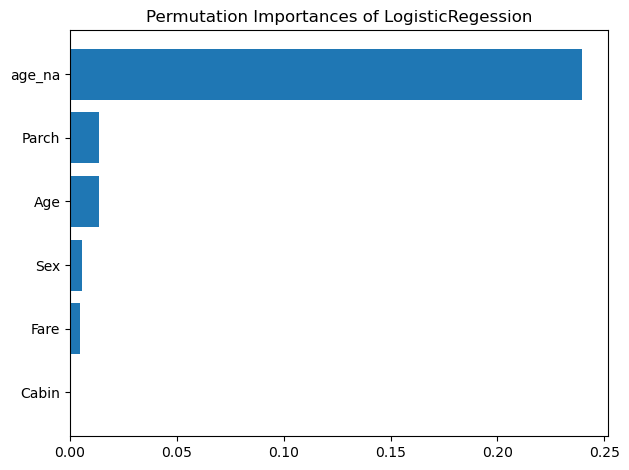

In [41]:
params = pipe_parm()
method = 'LogisticRegession'
gs_lr_pipe = GridSearchCV(estimator = LR_pipe, 
                           param_grid = params[method],
                           scoring = 'accuracy',
                           cv = cross_validation)
gs_lr_pipe.fit(X_train_v, y_train)    
plt_keys(gs_lr_pipe, method, X_test_v, y_test)

In [43]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def test_data(pipe):
    new_df = pd.read_csv(dataset_dir +'test.csv')
    new_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    X_test = new_df[FEATURES]
    y_test =  pd.read_csv(dataset_dir +'gender_submission.csv')['Survived']
    X_valid = pipe_data_process().fit_transform(X_test)

    y_pred_test = pipe.predict(X_valid)
    result = pd.DataFrame(y_pred_test, columns = ["Survived"])
    result['PassengerId'] = new_df['PassengerId']
    result.to_csv('result.csv', index=False)
    
    cm = confusion_matrix(y_test, y_pred_test)
    print(f'confusion matrix {cm}')
    plot_confusion_matrix(cm)
    plt.show()

[Pipeline]  (step 1 of 6) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 6) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 6) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 6) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 6) Processing log, total=   0.0s
confusion matrix [[256  10]
 [  7 145]]


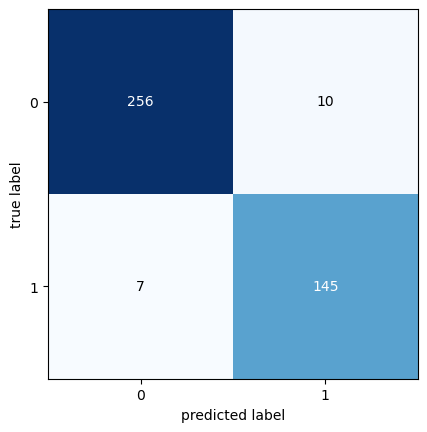

In [44]:
test_data(gs_lr_pipe)